In [1]:
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
import random
import matplotlib.pyplot as plt
from pycaret.classification import *
from sklearn.model_selection import train_test_split

import sys
sys.path.append('../../../scripts/')
from PreparaDatasetV2 import *

# Parâmetros do método

In [2]:
TARGET = 'Back_Home'
ODDS = 'Odds_H'

# Carregando o dataset

In [3]:
data = pd.read_csv('../../../data/Entire_Season.csv')
data = prepara_df(data)

In [4]:
def prepara_dataset(_df):

    _df = _df[(_df['Odds_H'] >= 1.6) & (_df['Odds_H'] <= 2.4)]

    _df.replace([np.inf, -np.inf], 0, inplace=True)
    _df.reset_index(drop=True, inplace=True)
    
    return _df

In [204]:
df = data.copy()
df = prepara_dataset(df)

In [212]:
treino, val = train_test_split(df, train_size=0.66, random_state=4000)

print(f'Treino: {treino.shape[0]} | Validação: {val.shape[0]}')

Treino: 1629 | Validação: 840


# Criação do modelo

In [213]:
features = ['Over_Line', 'HA_Line',
       'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 'P(O)', 'P(U)', 'P_Diff', 
       'Avg_CG_H', 'DP_CG_H', 'CV_CG_H', 'Avg_Pontos_H',
       'DP_Pontos_H', 'CV_Pontos_H', 'CG_H_Last_Game', 'Media_Odds_Geral_H',
       'DP_Odds_Geral_H', 'CV_Odds_Geral_H', 'Saldo_Gols_H', 'Avg_CG_A',
       'DP_CG_A', 'CV_CG_A', 'Avg_Pontos_A', 'DP_Pontos_A', 'CV_Pontos_A',
       'CG_A_Last_Game', 'Media_Odds_Geral_A', 'DP_Odds_Geral_A',
       'CV_Odds_Geral_A', 'Saldo_Gols_A', 'Goals_Last_H', 'Goals_Last_A',
       'Last_Odd_H', 'Last_Odd_A', 'MediaCustoGolHome', 'MediaCustoGolAway',
       'CV_ML', 'CV_Over', 'CV_HA', 'Retornos_BH_Acu', 'Avg_Retornos_BH',
       'Custo_Retorno_BH', 'Avg_Porc_BH_Bookie', 'Avg_Porc_BH_Real',
       'Dist_Porc_BH', 'Retornos_BA_Acu', 'Avg_Retornos_BA',
       'Custo_Retorno_BA', 'Avg_Porc_BA_Bookie', 'Avg_Porc_BA_Real',
       'Dist_Porc_BA', ODDS]

features = ['Goals_Last_H', 'P(U)', 'Avg_CG_H', 'Dist_Porc_BA', 'Avg_Retornos_BH', 'Last_Odd_H', 'CV_Odds_Geral_H', 'Odds_H']

In [265]:
def cria_setup(features, seed = 2023):
    cls = setup(data = treino,
            ignore_features = [x for x in treino.columns.to_list() if x not in features and x != TARGET],
            target = TARGET,
            train_size = 0.5,
            normalize = True,
            normalize_method = 'minmax',
            session_id = seed,
            remove_outliers = True,
            # fix_imbalance = True,
            verbose = False
            )

In [269]:
cria_setup(seed = 6891, features = features)

xtrain_treino = get_config('X_train')
ytrain_treino = get_config('y_train')
xtrain_teste = get_config('X_test')
ytrain_teste = get_config('y_test')

real_treino = pd.concat([xtrain_treino, ytrain_treino], axis=1)
real_teste = pd.concat([xtrain_teste, ytrain_teste],  axis=1)

In [216]:
top = compare_models(exclude=['catboost', 'dummy'], fold = 5, sort='precision', n_select=14)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5616,0.5812,0.5589,0.5660,0.5618,0.1231,0.1235,0.0480
ridge,Ridge Classifier,0.5603,0.0000,0.5565,0.5654,0.5601,0.1206,0.1212,0.0460
lda,Linear Discriminant Analysis,0.5505,0.5756,0.5443,0.5555,0.5491,0.1010,0.1015,0.0460
gbc,Gradient Boosting Classifier,0.5443,0.5666,0.5245,0.5495,0.5357,0.0885,0.0890,0.0740
nb,Naive Bayes,0.5394,0.5523,0.5224,0.5449,0.5311,0.0795,0.0797,0.0420
et,Extra Trees Classifier,0.5356,0.5464,0.4656,0.5432,0.5002,0.0714,0.0722,0.0820
qda,Quadratic Discriminant Analysis,0.5283,0.5330,0.5004,0.5346,0.5141,0.0574,0.0579,0.0440
dt,Decision Tree Classifier,0.5245,0.5258,0.4828,0.5285,0.5043,0.0492,0.0495,0.0440
knn,K Neighbors Classifier,0.5270,0.5414,0.4905,0.5277,0.5062,0.0546,0.0551,0.0500
rf,Random Forest Classifier,0.5221,0.5382,0.4560,0.5269,0.4881,0.0447,0.0452,0.0860


In [270]:
model = create_model('lr', fold = 5, return_train_score=True)

In [254]:
# Ranges da variável
ranges_dict['Last_Odd_H']['range']

Interval(1.59, 2.306, closed='right')

In [255]:
def filtra_resultados(_df, filtro = 0):
    _df = _df[_df['prediction_label'] == 1]

    if filtro == 1:
        _df = _df[((_df['CV_Odds_Geral_H'] <= 0.224) | (_df['CV_Odds_Geral_H'] > 0.441))]
        _df = _df[((_df['P(U)'] < 0.526) | (_df['P(U)'] > 0.535))]
        _df = _df[((_df['Last_Odd_H'] <= 1.59) | (_df['Last_Odd_H'] > 2.3))]

    return _df

In [30]:
def calcula_profit(_df, stake = 1):
    _df.loc[(_df[TARGET] == 1), 'PL_BF_Predictions'] = (_df[ODDS] - 1) * stake
    _df.loc[(_df[TARGET] == 0), 'PL_BF_Predictions'] = - stake

    return _df

def exibe_metricas(_df, total, stake = 1, return_metrics = False):
    _df['Acumulado'] = _df['PL_BF_Predictions'].cumsum()
    _df['Drawdown'] = _df['Acumulado'] - _df['Acumulado'].cummax()
    plb = _df['PL_BF_Predictions'].sum()
    entradas = _df.shape[0]
    wr = round((_df[_df[TARGET] == 1].shape[0] / entradas), 2)
    oddback = (_df[ODDS].mean())
    med_gain = _df[_df[TARGET] == 1]['PL_BF_Predictions'].mean()
    med_loss = _df[_df[TARGET] == 0]['PL_BF_Predictions'].mean()
    roi = plb / entradas
    porc_ent = entradas / total
    ev = (wr*stake*med_gain) + ((1-wr)*med_loss*stake)
    dd = _df['Drawdown'].min()

    if return_metrics == False:
        print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | Prec.: {wr:.2f}')
        print(f'Odd média: {oddback:.2f} ({1/oddback:.2f} WR)')
        print(f'Média Gain: {med_gain:.2f} | Média Loss: {med_loss:.2f}')
        print(f'EM: {ev:.2f}')
        print(f'Máx Drawndown: {dd:.2f}')
        print(f'{entradas} entradas em {total} jogos ({100*porc_ent:.2f}%)')
    else:
        return_metrics == True
        metrics = {
            'pl': plb,
            'wr': wr,
            'dd': dd,
            'oddback': oddback,
            'med_gain': med_gain,
            'med_loss': med_loss,
            'roi': roi,
            'porc_ent': porc_ent,
            'ev': ev,
        }
        return metrics

def exibe_grafico(_df, per_day = False):
    _df['Date'] = pd.to_datetime(_df['Date'])
    _df.sort_values('Date', inplace=True)
    _df.reset_index(drop=True, inplace=True)
    
    if per_day:
        _df_per_day = _df.groupby(_df['Date'].dt.date)['PL_BF_Predictions'].sum()
        _df_per_day = _df_per_day.reset_index()
        
        # Criar um novo DataFrame com colunas 'Date' e 'Accumulated'
        new_df = pd.DataFrame({
            'Date': _df_per_day['Date'],
            'PL': _df_per_day['PL_BF_Predictions']
        })

        new_df['hbacu'] = new_df['PL'].cumsum()
        new_df['hbacu'].plot.line(figsize=(7, 2))
        plt.xlabel('Index')
        plt.ylabel('Acumulado')
        plt.title('Acumulado por dia')
        plt.show()

    else:
        _df['hbacu'] = _df['PL_BF_Predictions'].cumsum()
        _df['hbacu'].plot.line(figsize=(7, 2))
        plt.xlabel('Index')
        plt.ylabel('Acumulado')
        plt.title('Acumulado por jogo')
        plt.show()

def treina_modelo(modelo, data):
    _df = predict_model(modelo, data, verbose = False)
    _df = _df.merge(df[[TARGET, 'Date']], left_index=True, right_index=True, how='left')
    if f'{TARGET}_x' in _df.columns.tolist():
        _df.rename(columns={f'{TARGET}_x': TARGET}, inplace=True)
        _df.drop(columns=f'{TARGET}_y', inplace=True)
    if 'Date_x' in _df.columns.tolist():
        _df.rename(columns={'Date_x': 'Date'}, inplace=True)
        _df.drop(columns='Date_y', inplace=True)
    
    return _df

def info_modelo(modelo, data, stake = 1, filtro = 0, per_day = False, show_info = True):
    total = data.shape[0]

    _df = treina_modelo(modelo, data)
    _df = filtra_resultados(_df, filtro=filtro)
    _df = calcula_profit(_df, stake)
    if show_info:
        exibe_metricas(_df, total, stake)
        exibe_grafico(_df, per_day)
    
    return _df


----------------- TREINO -----------------


----------------- TESTE -----------------


----------------- TREINAMENTO COMPLETO -----------------
PL: 18.00 | ROI: 8.22% | Prec.: 0.61
Odd média: 1.78 (0.56 WR)
Média Gain: 0.77 | Média Loss: -1.00
EM: 0.08
Máx Drawndown: -7.91
219 entradas em 1629 jogos (13.44%)


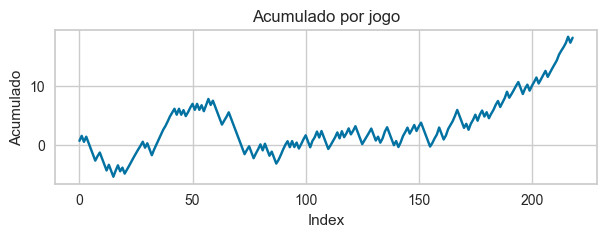



----------------- VALIDAÇÃO -----------------
PL: 11.34 | ROI: 11.12% | Prec.: 0.62
Odd média: 1.81 (0.55 WR)
Média Gain: 0.80 | Média Loss: -1.00
EM: 0.12
Máx Drawndown: -6.89
102 entradas em 840 jogos (12.14%)


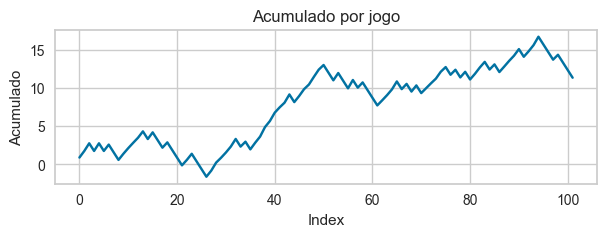

In [271]:
flt = 1
mdl = model

print('----------------- TREINO -----------------')
df_treino = info_modelo(mdl, real_treino, filtro = flt, show_info=False)
print('\n\n----------------- TESTE -----------------')
df_teste = info_modelo(mdl, real_teste, filtro = flt, show_info=False)
print('\n\n----------------- TREINAMENTO COMPLETO -----------------')
df_treinamento = info_modelo(mdl, treino, filtro = flt, show_info=True)
print('\n\n----------------- VALIDAÇÃO -----------------')
df_val = info_modelo(mdl, val, filtro = flt, show_info=True)

PL: 21.89 | ROI: 10.37% | Prec.: 0.62
Odd média: 1.79 (0.56 WR)
Média Gain: 0.78 | Média Loss: -1.00
EM: 0.10
Máx Drawndown: -6.89
211 entradas em 1655 jogos (12.75%)


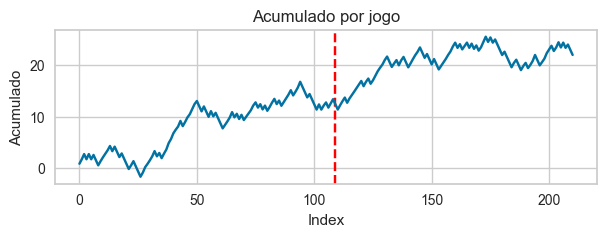

In [272]:
plt.axvline(x=len(df_teste), color='red', linestyle='--')

total = pd.concat([real_teste, val])
total.reset_index(drop=True, inplace=True)
total = info_modelo(mdl, total, filtro = flt, show_info=True)

# QCut automático

In [222]:
def find_pos_range(var, treino, teste, validacao, ratio = 0.03):
    nome = f'Cat_{var}'
    var_dict = {}

    # Usa qcut para definir os grupos
    treino[nome]  = pd.qcut(treino[var], q = 5, duplicates='drop')

    target = 'PL_BF_Predictions'
    pivot_table = pd.pivot_table(treino,
                                values=target,
                                index=[nome],
                                aggfunc=['sum', 'count']
                                )

    pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

    ranges = pivot_table[pivot_table['ratio'] > ratio].index.tolist()

    # Máscara booleana para filtrar o DataFrame
    mascara_treino = treino[var].apply(lambda x: any(x in range for range in ranges))
    mascara_teste = teste[var].apply(lambda x: any(x in range for range in ranges))
    mascara_val = validacao[var].apply(lambda x: any(x in range for range in ranges))
        
    # Aplicar a máscara para obter o DataFrame filtrado
    teste_filtrado = teste[mascara_teste]
    treino_filtrado = treino[mascara_treino]
    val_filtrado = validacao[mascara_val]
    
    metric_val = {}

    metric_treino = exibe_metricas(treino_filtrado, total=len(real_treino), return_metrics=True)
    metric_teste = exibe_metricas(teste_filtrado, total=len(real_teste), return_metrics=True)
    metric_val = exibe_metricas(val_filtrado, total=len(val), return_metrics=True)

    var_dict['range'] = ranges
    var_dict['metric_treino'] = metric_treino
    var_dict['metric_teste'] = metric_teste
    var_dict['metric_val'] = metric_val

    var_dict['range'] = ranges
    var_dict['metric_treino'] = metric_treino
    var_dict['metric_teste'] = metric_teste
    var_dict['metric_val'] = metric_val

    return var_dict


def find_top_range(var, treino, teste, validacao, ratio = 3):
    nome = f'Cat_{var}'
    var_dict = {}

    # Usa qcut para definir os grupos
    treino[nome]  = pd.qcut(treino[var], q = 5, duplicates='drop')

    target = 'PL_BF_Predictions'
    pivot_table = pd.pivot_table(treino,
                                values=target,
                                index=[nome],
                                aggfunc=['sum', 'count']
                                )
    

    pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

    pivot_table.sort_values('ratio', ascending=True, inplace=True)
    ranges = pivot_table.index.tolist()

    ranges = ranges[:ratio]

    # Máscara booleana para filtrar o DataFrame
    mascara_treino = treino[var].apply(lambda x: any(x in range for range in ranges))
    mascara_teste = teste[var].apply(lambda x: any(x in range for range in ranges))
    mascara_val = validacao[var].apply(lambda x: any(x in range for range in ranges))
    
    # Aplicar a máscara para obter o DataFrame filtrado
    teste_filtrado = teste[mascara_teste]
    treino_filtrado = treino[mascara_treino]
    val_filtrado = validacao[mascara_val]

    metric_val = {}

    metric_treino = exibe_metricas(treino_filtrado, total=len(real_treino), return_metrics=True)
    metric_teste = exibe_metricas(teste_filtrado, total=len(real_teste), return_metrics=True)
    metric_val = exibe_metricas(val_filtrado, total=len(val), return_metrics=True)

    var_dict['range'] = ranges
    var_dict['metric_treino'] = metric_treino
    var_dict['metric_teste'] = metric_teste
    var_dict['metric_val'] = metric_val

    var_dict['range'] = ranges
    var_dict['metric_treino'] = metric_treino
    var_dict['metric_teste'] = metric_teste
    var_dict['metric_val'] = metric_val

    return var_dict


def find_neg_range(var, treino, teste, validacao):
    nome = f'Cat_{var}'
    var_dict = {}

    # Usa qcut para definir os grupos
    treino[nome]  = pd.qcut(treino[var], q = 5, duplicates='drop')

    target = 'PL_BF_Predictions'
    pivot_table = pd.pivot_table(treino,
                                values=target,
                                index=[nome],
                                aggfunc=['sum', 'count']
                                )
    

    pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

    pivot_table.sort_values('ratio', ascending=True, inplace=True)
    ranges = pivot_table.index.tolist()
    
    # Pegar apenas o primeiro intervalo da lista
    range = ranges[0]

    # Criar a máscara booleana para valores dentro do primeiro intervalo
    mascara_treino = treino[var].apply(lambda x: x in range)
    mascara_teste = teste[var].apply(lambda x: x in range)
    mascara_val = validacao[var].apply(lambda x: x in range)

    mascara_treino = ~mascara_treino
    mascara_teste = ~mascara_teste
    mascara_val = ~mascara_val
    
    # Aplicar a máscara para obter o DataFrame filtrado
    treino_filtrado = treino[mascara_treino]
    teste_filtrado = teste[mascara_teste]
    val_filtrado = validacao[mascara_val]
    
    metric_val = {}

    metric_treino = exibe_metricas(treino_filtrado, total=len(real_treino), return_metrics=True)
    metric_teste = exibe_metricas(teste_filtrado, total=len(real_teste), return_metrics=True)
    metric_val = exibe_metricas(val_filtrado, total=len(val), return_metrics=True)

    var_dict['range'] = range
    var_dict['metric_treino'] = metric_treino
    var_dict['metric_teste'] = metric_teste
    var_dict['metric_val'] = metric_val

    return var_dict

In [251]:
autocut_treino = df_treino.copy()
autocut_teste = df_teste.copy()
autocut_val = df_val.copy()

In [252]:
variaveis = features.copy()
ranges_dict = {}

for var in variaveis:
    try:
        # new_dict = find_pos_range(var, treino = autocut_treino, teste = autocut_teste, validacao = autocut_val, ratio = 0.1)
        new_dict = find_neg_range(var, treino = autocut_treino, teste = autocut_teste, validacao=autocut_val)
        # new_dict = find_top_range(var, treino = autocut_treino, teste = autocut_teste, validacao = autocut_val, ratio = 3)
        ranges_dict[var] = new_dict
    except:
        pass

ordenado = {chave: valor for chave, valor in sorted(ranges_dict.items(), key=lambda item: item[1]['metric_teste']['wr'], reverse=True)}

In [253]:
for var in ordenado:
    print(f'{var}')
    print(f'treino: {ordenado[var]["metric_treino"]["wr"]:.2f}')
    # print(f'treino: {ordenado[var]["metric_treino"]["pl"]:.2f}')
    print(f'teste: {ordenado[var]["metric_teste"]["wr"]:.2f}')
    # print(f'teste: {ordenado[var]["metric_teste"]["pl"]:.2f}')
    print(f'val: {ordenado[var]["metric_val"]["wr"]:.2f}')
    # print(f'val: {ordenado[var]["metric_val"]["pl"]:.2f}')
    print(f'% Ent: {ordenado[var]["metric_teste"]["porc_ent"]:.2f}')
    print()

CV_Odds_Geral_H
treino: 0.68
teste: 0.73
val: 0.62
% Ent: 0.03

Avg_CG_H
treino: 0.64
teste: 0.64
val: 0.61
% Ent: 0.03

Avg_Retornos_BH
treino: 0.79
teste: 0.64
val: 0.65
% Ent: 0.02

P(U)
treino: 0.59
teste: 0.62
val: 0.62
% Ent: 0.17

Last_Odd_H
treino: 0.60
teste: 0.62
val: 0.62
% Ent: 0.13

Odds_H
treino: 0.61
teste: 0.60
val: 0.62
% Ent: 0.13

Goals_Last_H
treino: 0.60
teste: 0.59
val: 0.62
% Ent: 0.14

Dist_Porc_BA
treino: 0.70
teste: 0.58
val: 0.65
% Ent: 0.01



### comparação geral

In [ ]:
ordenado2 = {chave: valor for chave, valor in sorted(ranges_dict.items(), key=lambda item: item[1]['metric_val']['pl'], reverse=True)}

for var in ordenado2:
    print(f'{var}')
    print('Treino')
    print(f'WR: {ordenado2[var]["metric_treino"]["wr"]:.2f}')
    print(f'PL: {ordenado2[var]["metric_treino"]["pl"]:.2f}')
    print(f'ROI: {ordenado2[var]["metric_treino"]["roi"]:.2f}')
    print(f'DD: {ordenado2[var]["metric_treino"]["dd"]:.2f}')
    print(f'% Ent: {ordenado2[var]["metric_treino"]["porc_ent"]:.2f}')
    print()
    print('Teste')
    print(f'WR: {ordenado2[var]["metric_teste"]["wr"]:.2f}')
    print(f'PL: {ordenado2[var]["metric_teste"]["pl"]:.2f}')
    print(f'ROI: {ordenado2[var]["metric_teste"]["roi"]:.2f}')
    print(f'DD: {ordenado2[var]["metric_teste"]["dd"]:.2f}')
    print(f'% Ent: {ordenado2[var]["metric_teste"]["porc_ent"]:.2f}')
    print()
    print('Val')
    print(f'WR: {ordenado2[var]["metric_val"]["wr"]:.2f}')
    print(f'PL: {ordenado2[var]["metric_val"]["pl"]:.2f}')
    print(f'ROI: {ordenado2[var]["metric_val"]["roi"]:.2f}')
    print(f'DD: {ordenado2[var]["metric_val"]["dd"]:.2f}')
    print(f'% Ent: {ordenado2[var]["metric_val"]["porc_ent"]:.2f}')
    print()
    print('------------------------------------------------\n')

# Comparação de modelos

### Escolhendo os modelos

In [258]:
def compare(conjunto, modelo, filtro, i):
    try:
        if conjunto == 'val':
            print(f'{modelo.__class__.__name__} (i = {i})\n')
            aux = info_modelo(modelo, val, filtro = filtro)
        elif conjunto == 'teste_val':
            print(f'{modelo.__class__.__name__} (i = {i})\n')
            
            aux_total = info_modelo(modelo, real_teste, filtro = filtro, show_info=False)
            plt.axvline(x=len(aux_total), color='green', linestyle='--')
            aux = info_modelo(modelo, pd.concat([real_teste, val]), filtro = filtro)
        elif conjunto == 'teste':
            print(f'{modelo.__class__.__name__} (i = {i})\n')
            aux = info_modelo(modelo, real_teste, filtro = filtro)
    except:
        print(f'O modelo apresentou um erro.\n')
        pass
    print('\n')

In [259]:
FILTRO = 1
CONJUNTO = 'teste_val'

LogisticRegression (i = 0)

PL: 18.06 | ROI: 8.32% | Prec.: 0.62
Odd média: 1.77 (0.57 WR)
Média Gain: 0.75 | Média Loss: -1.00
EM: 0.09
Máx Drawndown: -7.71
217 entradas em 1655 jogos (13.11%)


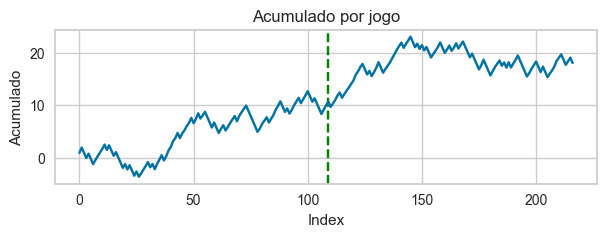



RidgeClassifier (i = 1)

PL: 17.37 | ROI: 8.04% | Prec.: 0.62
Odd média: 1.77 (0.57 WR)
Média Gain: 0.75 | Média Loss: -1.00
EM: 0.09
Máx Drawndown: -8.71
216 entradas em 1655 jogos (13.05%)


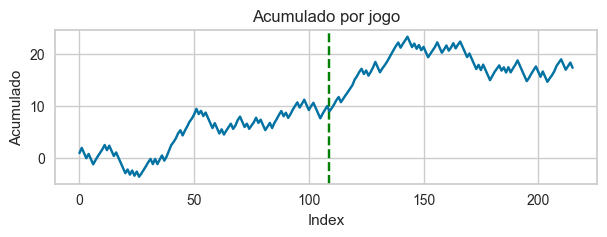



LinearDiscriminantAnalysis (i = 2)

PL: 16.37 | ROI: 7.54% | Prec.: 0.61
Odd média: 1.77 (0.56 WR)
Média Gain: 0.75 | Média Loss: -1.00
EM: 0.07
Máx Drawndown: -8.58
217 entradas em 1655 jogos (13.11%)


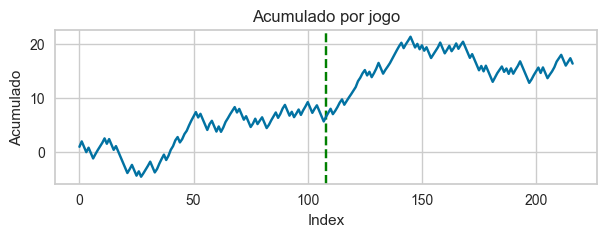



GradientBoostingClassifier (i = 3)

PL: -3.89 | ROI: -1.59% | Prec.: 0.54
Odd média: 1.87 (0.54 WR)
Média Gain: 0.81 | Média Loss: -1.00
EM: -0.02
Máx Drawndown: -15.43
245 entradas em 1655 jogos (14.80%)


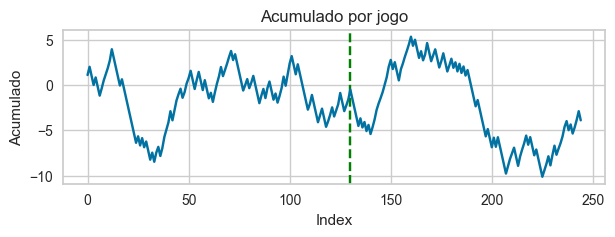



GaussianNB (i = 4)

PL: -1.29 | ROI: -0.60% | Prec.: 0.54
Odd média: 1.88 (0.53 WR)
Média Gain: 0.84 | Média Loss: -1.00
EM: -0.01
Máx Drawndown: -15.68
216 entradas em 1655 jogos (13.05%)


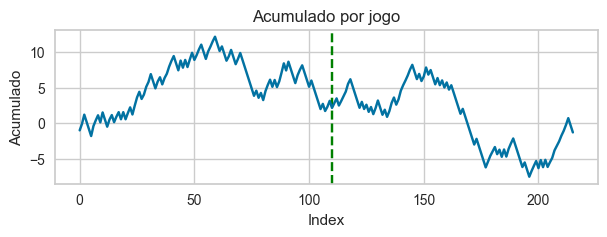



ExtraTreesClassifier (i = 5)

PL: 3.11 | ROI: 1.65% | Prec.: 0.56
Odd média: 1.87 (0.53 WR)
Média Gain: 0.81 | Média Loss: -1.00
EM: 0.01
Máx Drawndown: -12.21
189 entradas em 1655 jogos (11.42%)


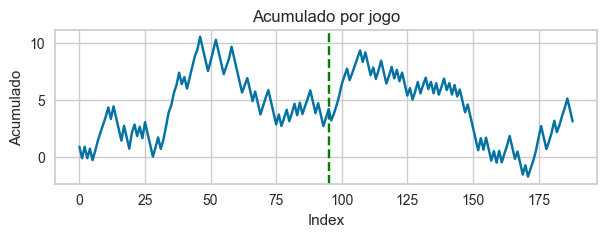



QuadraticDiscriminantAnalysis (i = 6)

PL: -2.73 | ROI: -1.48% | Prec.: 0.54
Odd média: 1.88 (0.53 WR)
Média Gain: 0.83 | Média Loss: -1.00
EM: -0.01
Máx Drawndown: -13.08
184 entradas em 1655 jogos (11.12%)


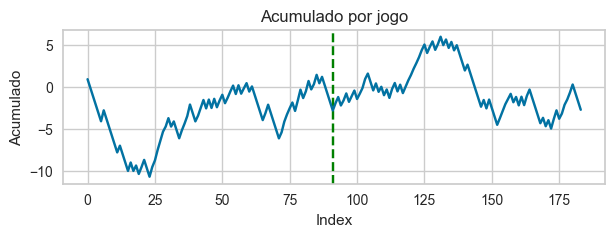



DecisionTreeClassifier (i = 7)

PL: -14.41 | ROI: -6.86% | Prec.: 0.50
Odd média: 1.91 (0.52 WR)
Média Gain: 0.85 | Média Loss: -1.00
EM: -0.08
Máx Drawndown: -24.35
210 entradas em 1655 jogos (12.69%)


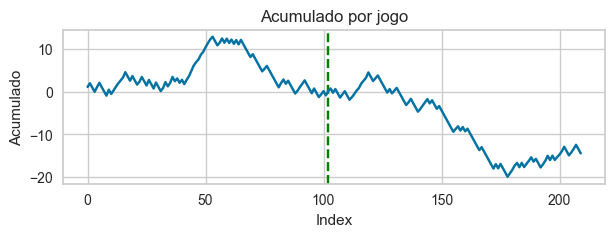



KNeighborsClassifier (i = 8)

PL: 3.70 | ROI: 1.86% | Prec.: 0.56
Odd média: 1.86 (0.54 WR)
Média Gain: 0.81 | Média Loss: -1.00
EM: 0.01
Máx Drawndown: -13.67
199 entradas em 1655 jogos (12.02%)


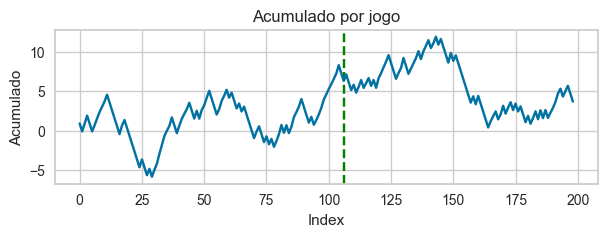



RandomForestClassifier (i = 9)

PL: 1.99 | ROI: 1.09% | Prec.: 0.56
Odd média: 1.87 (0.54 WR)
Média Gain: 0.80 | Média Loss: -1.00
EM: 0.01
Máx Drawndown: -13.00
182 entradas em 1655 jogos (11.00%)


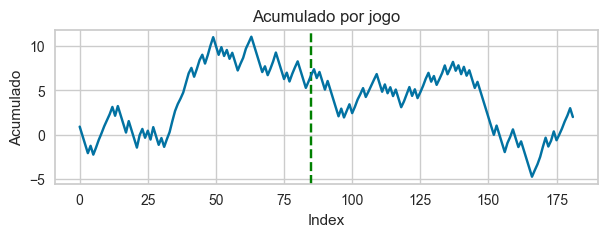



AdaBoostClassifier (i = 10)

PL: -2.07 | ROI: -0.90% | Prec.: 0.55
Odd média: 1.85 (0.54 WR)
Média Gain: 0.80 | Média Loss: -1.00
EM: -0.01
Máx Drawndown: -18.41
229 entradas em 1655 jogos (13.84%)


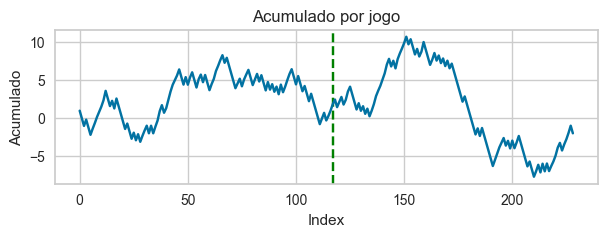



LGBMClassifier (i = 11)

PL: 6.58 | ROI: 3.16% | Prec.: 0.57
Odd média: 1.88 (0.53 WR)
Média Gain: 0.82 | Média Loss: -1.00
EM: 0.04
Máx Drawndown: -17.02
208 entradas em 1655 jogos (12.57%)


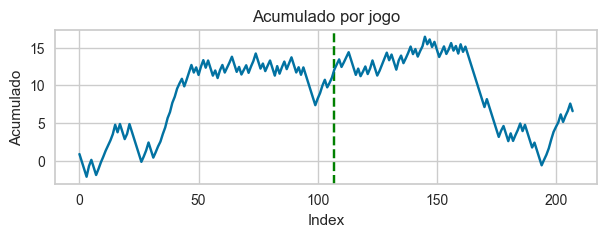



XGBClassifier (i = 12)

PL: 13.88 | ROI: 7.23% | Prec.: 0.59
Odd média: 1.88 (0.53 WR)
Média Gain: 0.82 | Média Loss: -1.00
EM: 0.07
Máx Drawndown: -12.86
192 entradas em 1655 jogos (11.60%)


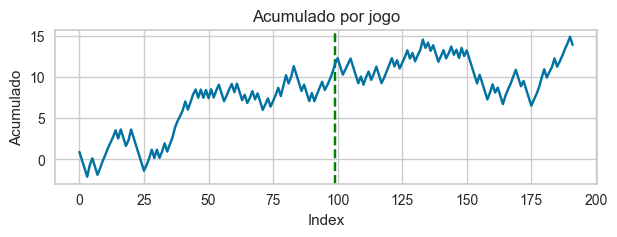



SGDClassifier (i = 13)

PL: -22.51 | ROI: -5.92% | Prec.: 0.51
Odd média: 1.90 (0.53 WR)
Média Gain: 0.84 | Média Loss: -1.00
EM: -0.06
Máx Drawndown: -27.70
380 entradas em 1655 jogos (22.96%)


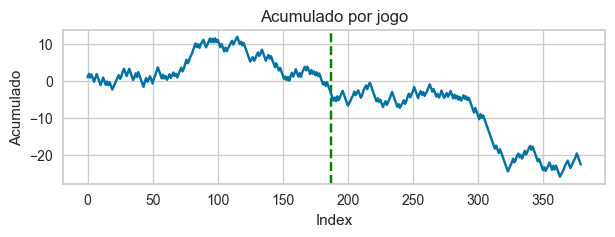

In [260]:
for i in range(14):
    compare(CONJUNTO, top[i], FILTRO, i)

In [ ]:
blended14 = blend_models(estimator_list = [top[1], top[4]], fold = 5, verbose=False)

In [ ]:
model_list = [top[1], top[4], blended14]

### Resultados

AdaBoostClassifier (i = 0)

PL: 25.05 | ROI: 9.08% | Prec.: 0.43
Odd média: 2.55 (0.39 WR)
Média Gain: 1.53 | Média Loss: -1.00
EM: 0.09
Máx Drawndown: -17.04
276 entradas em 1671 jogos (16.52%)


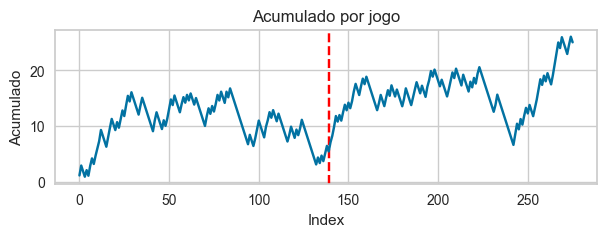

GradientBoostingClassifier (i = 1)

PL: 7.22 | ROI: 3.15% | Prec.: 0.41
Odd média: 2.52 (0.40 WR)
Média Gain: 1.49 | Média Loss: -1.00
EM: 0.02
Máx Drawndown: -22.87
229 entradas em 1671 jogos (13.70%)


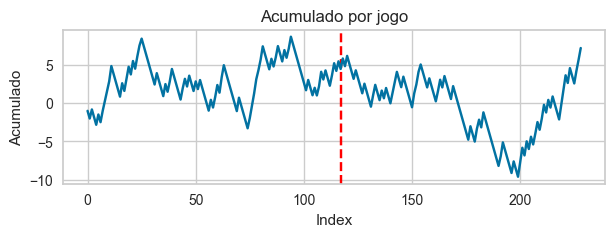

LGBMClassifier (i = 2)

PL: -22.85 | ROI: -9.89% | Prec.: 0.36
Odd média: 2.54 (0.39 WR)
Média Gain: 1.51 | Média Loss: -1.00
EM: -0.10
Máx Drawndown: -28.88
231 entradas em 1671 jogos (13.82%)


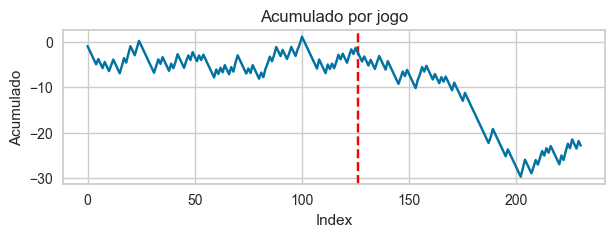

XGBClassifier (i = 3)

PL: -27.78 | ROI: -11.58% | Prec.: 0.35
Odd média: 2.53 (0.40 WR)
Média Gain: 1.50 | Média Loss: -1.00
EM: -0.13
Máx Drawndown: -35.34
240 entradas em 1671 jogos (14.36%)


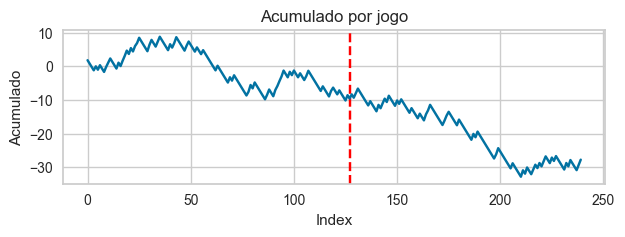

RandomForestClassifier (i = 4)

PL: 7.15 | ROI: 4.21% | Prec.: 0.42
Odd média: 2.50 (0.40 WR)
Média Gain: 1.50 | Média Loss: -1.00
EM: 0.05
Máx Drawndown: -15.21
170 entradas em 1671 jogos (10.17%)


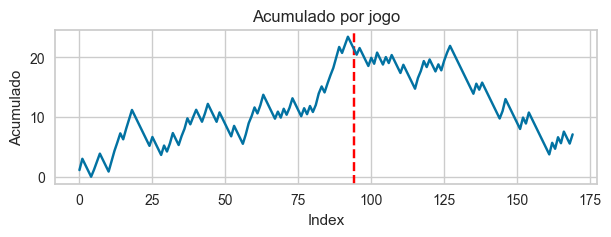

DecisionTreeClassifier (i = 5)

PL: -27.77 | ROI: -8.90% | Prec.: 0.36
Odd média: 2.60 (0.38 WR)
Média Gain: 1.56 | Média Loss: -1.00
EM: -0.08
Máx Drawndown: -35.62
312 entradas em 1671 jogos (18.67%)


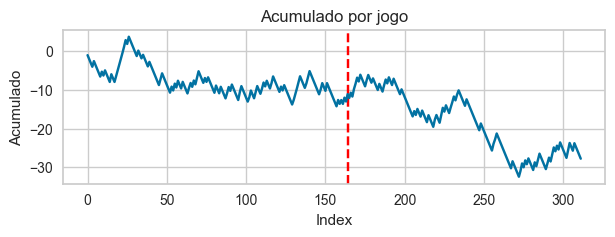

LogisticRegression (i = 6)

PL: 24.99 | ROI: 7.62% | Prec.: 0.44
Odd média: 2.47 (0.40 WR)
Média Gain: 1.47 | Média Loss: -1.00
EM: 0.09
Máx Drawndown: -17.01
328 entradas em 1671 jogos (19.63%)


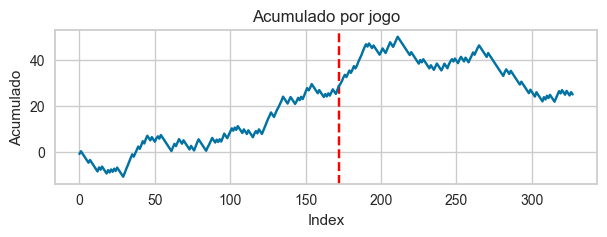

LinearDiscriminantAnalysis (i = 7)

PL: 1.44 | ROI: 0.43% | Prec.: 0.41
Odd média: 2.48 (0.40 WR)
Média Gain: 1.47 | Média Loss: -1.00
EM: 0.01
Máx Drawndown: -25.49
335 entradas em 1671 jogos (20.05%)


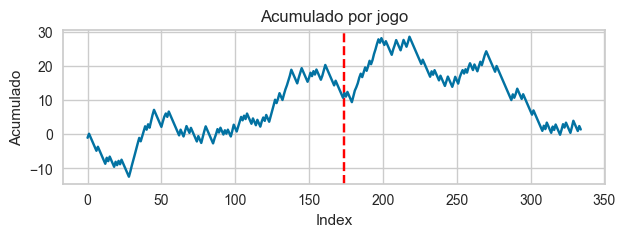

RidgeClassifier (i = 8)

PL: 14.33 | ROI: 4.25% | Prec.: 0.42
Odd média: 2.48 (0.40 WR)
Média Gain: 1.47 | Média Loss: -1.00
EM: 0.04
Máx Drawndown: -21.67
337 entradas em 1671 jogos (20.17%)


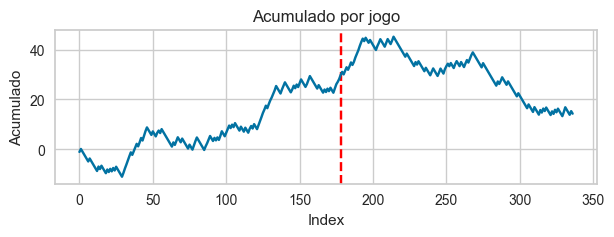

KNeighborsClassifier (i = 9)

PL: -12.58 | ROI: -4.07% | Prec.: 0.38
Odd média: 2.60 (0.38 WR)
Média Gain: 1.56 | Média Loss: -1.00
EM: -0.03
Máx Drawndown: -25.21
309 entradas em 1671 jogos (18.49%)


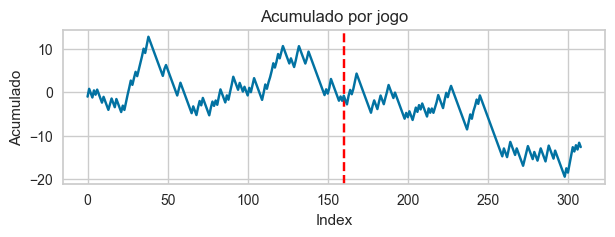

GaussianNB (i = 10)

PL: 11.83 | ROI: 2.67% | Prec.: 0.40
Odd média: 2.57 (0.39 WR)
Média Gain: 1.56 | Média Loss: -1.00
EM: 0.02
Máx Drawndown: -24.72
443 entradas em 1671 jogos (26.51%)


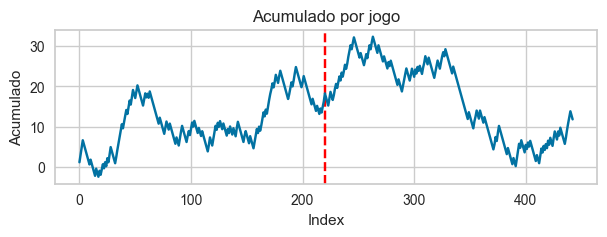

QuadraticDiscriminantAnalysis (i = 11)

PL: -16.27 | ROI: -4.60% | Prec.: 0.37
Odd média: 2.59 (0.39 WR)
Média Gain: 1.56 | Média Loss: -1.00
EM: -0.05
Máx Drawndown: -30.07
354 entradas em 1671 jogos (21.18%)


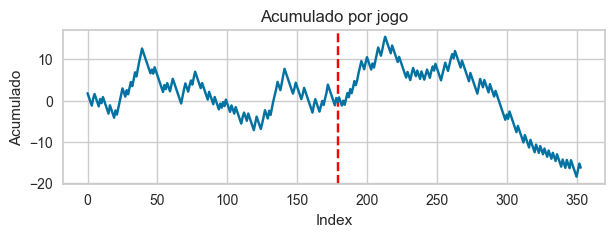

ExtraTreesClassifier (i = 12)

PL: -3.56 | ROI: -2.80% | Prec.: 0.39
Odd média: 2.52 (0.40 WR)
Média Gain: 1.52 | Média Loss: -1.00
EM: -0.02
Máx Drawndown: -13.22
127 entradas em 1671 jogos (7.60%)


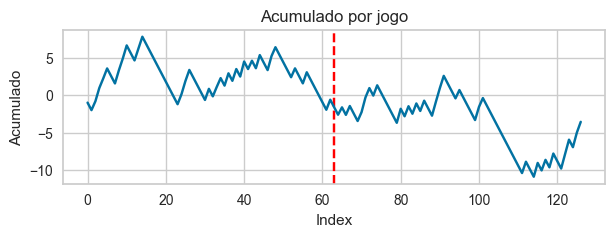

SGDClassifier (i = 13)

PL: -6.61 | ROI: -16.95% | Prec.: 0.36
Odd média: 2.31 (0.43 WR)
Média Gain: 1.31 | Média Loss: -1.00
EM: -0.17
Máx Drawndown: -9.51
39 entradas em 1671 jogos (2.33%)


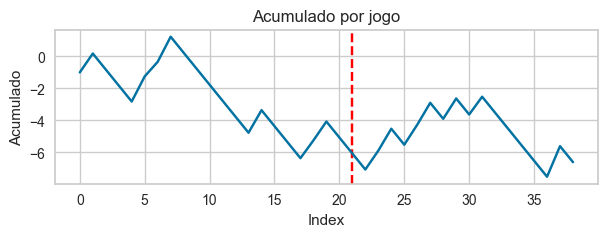

In [246]:
FILTRO = 1
CONJUNTO = 'teste_val'

for i in range(14):
    try:
        if CONJUNTO == 'val':
            print(f'{top[i].__class__.__name__} (i = {i})\n')
            aux_total = treina_modelo(top[i], val1)
            aux_total = filtra_resultados(aux_total, filtro = FILTRO)
            plt.axvline(x=len(aux_total), color='red', linestyle='--')
            aux = info_modelo(top[i], val, filtro = FILTRO)
        elif CONJUNTO == 'teste_val':
            print(f'{top[i].__class__.__name__} (i = {i})\n')
            aux_total = treina_modelo(top[i], real_teste)
            aux_total = filtra_resultados(aux_total, filtro = FILTRO)
            plt.axvline(x=len(aux_total), color='red', linestyle='--')
            aux = info_modelo(top[i], pd.concat([real_teste, val]), filtro = FILTRO)
        elif CONJUNTO == 'teste':
            print(f'{top[i].__class__.__name__} (i = {i})\n')
            aux = info_modelo(top[i], real_teste, filtro = FILTRO)
    except:
        print(f'O modelo apresentou um erro.\n')
        pass

# Script qcut

In [120]:
# df_cut1 = df_treino.copy()
df_cut = df_teste.copy()
# df_cut = pd.concat([df_cut1, df_cut2])

In [121]:
variaveis = features.copy()

for var in variaveis:
    try:
        nome = f'Cat_{var}'
        # Usa qcut para definir os grupos
        df_cut[nome]  = pd.qcut(df_cut[var], q = 5, duplicates='drop')

        target = 'PL_BF_Predictions'
        pivot_table = pd.pivot_table(df_cut,
                                    values=target,
                                    index=[nome],
                                    aggfunc=['sum', 'count']
                                    )
        

        pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

        aux_treino = pivot_table[pivot_table['ratio'] != 0]


        print(var)
        print(aux_treino)
        print()
        print('\n\n')
        print('------------------------------------------------')
        print('\n\n')
    except:
        pass

Prob_0GH
                              sum             count     ratio
                PL_BF_Predictions PL_BF_Predictions          
Cat_Prob_0GH                                                 
(0.0531, 0.155]         13.900000               263  0.052852
(0.155, 0.223]          -3.750001               186 -0.020161
(0.223, 0.239]         -38.590000                76 -0.507763




------------------------------------------------



BTTS_No
                                         sum             count     ratio
                           PL_BF_Predictions PL_BF_Predictions          
Cat_BTTS_No                                                             
(1.3590000000000002, 1.62]          1.799999               111  0.016216
(1.62, 1.69]                       -3.810001               102 -0.037353
(1.69, 1.75]                       -2.090000               106 -0.019717
(1.75, 1.84]                      -17.520000               115 -0.152348
(1.84, 2.39]                       -0.740000

# Script variáveis

In [56]:
colunas = ['Over_Line', 'HA_Line',
       'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 'P(O)', 'P(U)', 'P_Diff', 
       'Avg_CG_H', 'DP_CG_H', 'CV_CG_H', 'Avg_Pontos_H',
       'DP_Pontos_H', 'CV_Pontos_H', 'CG_H_Last_Game', 'Media_Odds_Geral_H',
       'DP_Odds_Geral_H', 'CV_Odds_Geral_H', 'Saldo_Gols_H', 'Avg_CG_A',
       'DP_CG_A', 'CV_CG_A', 'Avg_Pontos_A', 'DP_Pontos_A', 'CV_Pontos_A',
       'CG_A_Last_Game', 'Media_Odds_Geral_A', 'DP_Odds_Geral_A',
       'CV_Odds_Geral_A', 'Saldo_Gols_A', 'Goals_Last_H', 'Goals_Last_A',
       'Last_Odd_H', 'Last_Odd_A', 'MediaCustoGolHome', 'MediaCustoGolAway',
       'CV_ML', 'CV_Over', 'CV_HA', 'Retornos_BH_Acu', 'Avg_Retornos_BH',
       'Custo_Retorno_BH', 'Avg_Porc_BH_Bookie', 'Avg_Porc_BH_Real',
       'Dist_Porc_BH', 'Retornos_BA_Acu', 'Avg_Retornos_BA',
       'Custo_Retorno_BA', 'Avg_Porc_BA_Bookie', 'Avg_Porc_BA_Real',
       'Dist_Porc_BA']

In [57]:
import random

def pegar_elementos_aleatorios(lista):
    # Gerar um número aleatório entre 2 e 7
    num_elementos = random.randint(10, 30)

    # Garantir que o número de elementos não ultrapasse o tamanho da lista
    num_elementos = min(num_elementos, len(lista))

    # Selecionar elementos aleatórios da lista
    elementos_aleatorios = random.sample(lista, num_elementos)

    return elementos_aleatorios

In [98]:
def cria_modelo(fts, _seed = 2023, _filtro = 0):
        try:
                cria_setup(features=fts, seed = _seed)

                model = create_model('lr', verbose = False, fold = 5)
                tab = pull()
                prec_model = (tab.loc['Mean', 'Prec.'])
                std_model = (tab.loc['Std', 'Prec.'])
                std_model = std_model * 100
                previsoes = predict_model(model, verbose = False)

                stake = 1

                total = previsoes.shape[0]

                previsoes = previsoes[previsoes['prediction_label'] == 1]
                previsoes = filtra_resultados(previsoes, filtro = _filtro)

                previsoes.loc[(previsoes[TARGET] == 1), 'PL_BF_Predictions'] = (previsoes[ODDS] - 1) * stake
                previsoes.loc[(previsoes[TARGET] == 0), 'PL_BF_Predictions'] = - stake

                plb = previsoes['PL_BF_Predictions'].sum()
                entradas = previsoes.shape[0]
                wr = round((previsoes[previsoes[TARGET] == 1].shape[0] / entradas), 2)
                oddback = previsoes[previsoes['prediction_label'] == 1][ODDS].mean()
                med_gain = previsoes[previsoes[TARGET] == 1]['PL_BF_Predictions'].mean()
                med_loss = previsoes[previsoes[TARGET] == 0]['PL_BF_Predictions'].mean()
                roi = plb / entradas
                porc_ent = entradas / total
                ev = (wr*stake*med_gain) + ((1-wr)*med_loss*stake)

                metrics = [prec_model, std_model, plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev]

                return metrics
        except Exception as e:
                print(e)
                return [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [97]:
melhor_PL = -10000

for i in range(20):
    feats = pegar_elementos_aleatorios(colunas)
    feats.extend([ODDS])

    metrics = cria_modelo(fts=feats)
    prec_model, std_model, plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev = metrics
            
    print(f'Rodada {i+1}')
    if plb > melhor_PL:
        melhor_PL = plb
        print(f'**Novo melhor**')
        print(f'Precision: {prec_model:.4f} ({std_model:.2f})')
        print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | EM: {ev:.2f} | Prec.: {wr:.2f} | Entradas: {porc_ent:.2f}')
        print(f'features = {feats}\n')
    print()

Rodada 1
**Novo melhor**
Precision: 0.4385 (22.27)
PL: -30.21 | ROI: -7.19% | EM: -0.07 | Prec.: 0.52 | Entradas: 0.52
features = ['Custo_Retorno_BH', 'Avg_Retornos_BH', 'Media_Odds_Geral_A', 'Avg_Porc_BH_Real', 'Media_Odds_Geral_H', 'Retornos_BH_Acu', 'Avg_Retornos_BA', 'Avg_Pontos_A', 'Custo_Retorno_BA', 'Dist_Porc_BH', 'Odds_H']


Rodada 2
**Novo melhor**
Precision: 0.5263 (3.44)
PL: -17.61 | ROI: -4.09% | EM: -0.03 | Prec.: 0.54 | Entradas: 0.53
features = ['CV_Pontos_A', 'Avg_Retornos_BH', 'P(A)', 'Dist_Porc_BA', 'Last_Odd_A', 'CV_Pontos_H', 'DP_Odds_Geral_H', 'Retornos_BH_Acu', 'CV_CG_H', 'DP_CG_A', 'Odds_H']


Rodada 3

Rodada 4
**Novo melhor**
Precision: 0.5531 (4.40)
PL: -10.46 | ROI: -3.15% | EM: -0.04 | Prec.: 0.54 | Entradas: 0.41
features = ['CV_Pontos_H', 'Avg_Porc_BA_Real', 'P_Diff', 'P(U)', 'DP_Odds_Geral_A', 'Dist_Porc_BH', 'HA_Odds_A', 'Saldo_Gols_H', 'CV_ML', 'P(H)', 'DP_CG_A', 'DP_Odds_Geral_H', 'Odds_H']


Rodada 5

Rodada 6

Rodada 7
**Novo melhor**
Precision: 0.5

In [81]:
# LR

Rodada 16
**Novo melhor**
Precision: 0.5421
PL: -7.92 | ROI: -1.86% | EM: -0.02 | Prec.: 0.56 | Entradas: 0.52
features = ['MediaCustoGolHome', 'CV_CG_H', 'CV_Pontos_A', 'Media_Odds_Geral_H', 'DP_Odds_Geral_A', 'DP_Odds_Geral_H', 'DP_CG_A', 'Retornos_BH_Acu', 'Avg_CG_H', 'Avg_Retornos_BA', 'Avg_CG_A', 'P(U)', 'Retornos_BA_Acu', 'Goals_Last_H', 'CV_Odds_Geral_H', 'Odds_H']


# Segundo filtro

In [92]:
fits = ['DP_Odds_Geral_A', 'Goals_Last_H', 'P(U)', 'Avg_CG_H', 'Dist_Porc_BA', 'Avg_Retornos_BA', 'Avg_Retornos_BH', 'Last_Odd_H', 'CV_Odds_Geral_H', 'P(H)', 'Odds_H']

fits = ['DP_Odds_Geral_A', 'Goals_Last_H', 'P(U)', 'Avg_CG_H', 'Dist_Porc_BA', 'Avg_Retornos_BH', 'Last_Odd_H', 'CV_Odds_Geral_H', 'P(H)', 'Odds_H']

fits = ['DP_Odds_Geral_A', 'Goals_Last_H', 'P(U)', 'Avg_CG_H', 'Dist_Porc_BA', 'Avg_Retornos_BH', 'Last_Odd_H', 'CV_Odds_Geral_H', 'Odds_H']

fits = ['Goals_Last_H', 'P(U)', 'Avg_CG_H', 'Dist_Porc_BA', 'Avg_Retornos_BH', 'Last_Odd_H', 'CV_Odds_Geral_H', 'Odds_H']

In [93]:
metrics = cria_modelo(fits)
prec_model, std_model, plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev = metrics

print('---------------------- BASE ----------------------')
print(f'Precision: {prec_model:.2f} ({std_model:.2f})')
print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | EM: {ev:.2f} | Prec.: {wr:.2f} | Entradas: {porc_ent:.2f}')
print(f'fits = {fits}\n')
print('--------------------------------------------------')
melhor_PL = plb

for i in range(len(fits) - 1):
    feat = fits[i]
    fits.pop(i)
    print(f'Removido: {feat}')

    metrics = cria_modelo(fits)
    prec_model, std_model, plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev = metrics

    if plb >= melhor_PL:
        print('*** NOVO MELHOR ***')
        melhor_PL = plb
    print(f'Precision: {prec_model:.2f} ({std_model:.2f})')
    print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | EM: {ev:.2f} | Prec.: {wr:.2f} | Entradas: {porc_ent:.2f}')
    print(f'fits = {fits}\n')
    fits.insert(i, feat)
    print()

---------------------- BASE ----------------------
Precision: 0.55 (2.91)
PL: 2.55 | ROI: 0.59% | EM: 0.01 | Prec.: 0.58 | Entradas: 0.53
fits = ['Goals_Last_H', 'P(U)', 'Avg_CG_H', 'Dist_Porc_BA', 'Avg_Retornos_BH', 'Last_Odd_H', 'CV_Odds_Geral_H', 'Odds_H']

--------------------------------------------------
Removido: Goals_Last_H
Precision: 0.55 (2.66)
PL: -4.43 | ROI: -1.02% | EM: -0.00 | Prec.: 0.57 | Entradas: 0.53
fits = ['P(U)', 'Avg_CG_H', 'Dist_Porc_BA', 'Avg_Retornos_BH', 'Last_Odd_H', 'CV_Odds_Geral_H', 'Odds_H']


Removido: P(U)
Precision: 0.55 (2.96)
PL: -0.76 | ROI: -0.17% | EM: -0.00 | Prec.: 0.57 | Entradas: 0.53
fits = ['Goals_Last_H', 'Avg_CG_H', 'Dist_Porc_BA', 'Avg_Retornos_BH', 'Last_Odd_H', 'CV_Odds_Geral_H', 'Odds_H']


Removido: Avg_CG_H
Precision: 0.55 (3.66)
PL: 1.58 | ROI: 0.37% | EM: -0.00 | Prec.: 0.57 | Entradas: 0.53
fits = ['Goals_Last_H', 'P(U)', 'Dist_Porc_BA', 'Avg_Retornos_BH', 'Last_Odd_H', 'CV_Odds_Geral_H', 'Odds_H']


Removido: Dist_Porc_BA
Prec

# Cross validation

Fold 1 (seed 8520)
PL: 1.97 | ROI: 1.73% | EM: 0.02 | Prec.: 0.57 | Entradas: 0.14
Drawndown: -8.61


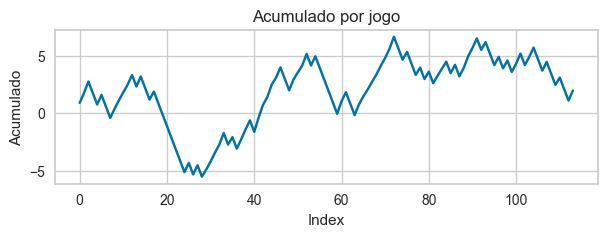


Fold 2 (seed 358)
PL: 2.37 | ROI: 2.58% | EM: 0.03 | Prec.: 0.58 | Entradas: 0.11
Drawndown: -7.89


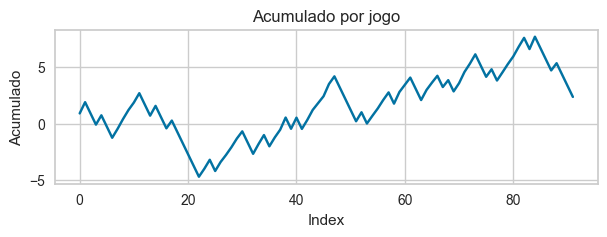


Fold 3 (seed 7492)
PL: 5.53 | ROI: 5.37% | EM: 0.05 | Prec.: 0.60 | Entradas: 0.12
Drawndown: -7.59


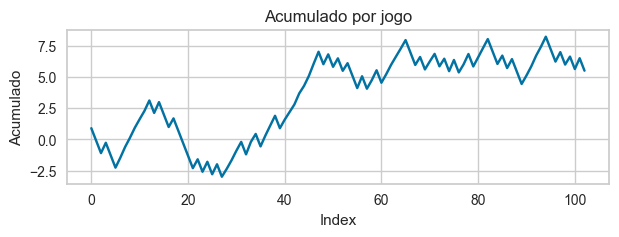


Fold 4 (seed 5013)
PL: 7.63 | ROI: 7.34% | EM: 0.08 | Prec.: 0.61 | Entradas: 0.12
Drawndown: -6.89


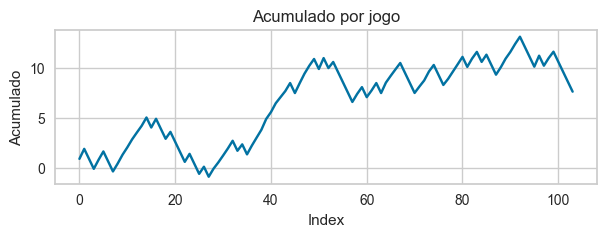


Fold 5 (seed 3024)
PL: 6.31 | ROI: 6.93% | EM: 0.06 | Prec.: 0.60 | Entradas: 0.11
Drawndown: -6.89


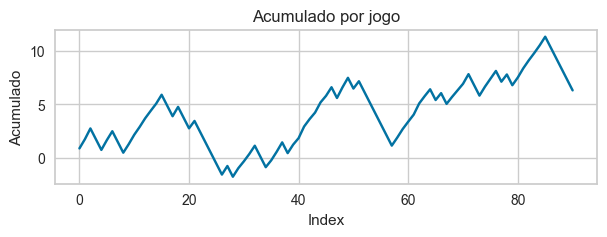


Fold 6 (seed 7535)
PL: 9.38 | ROI: 11.04% | EM: 0.12 | Prec.: 0.64 | Entradas: 0.10
Drawndown: -4.63


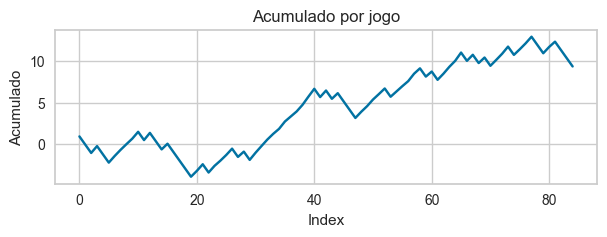


Fold 7 (seed 8115)
PL: 7.29 | ROI: 6.88% | EM: 0.06 | Prec.: 0.59 | Entradas: 0.13
Drawndown: -8.28


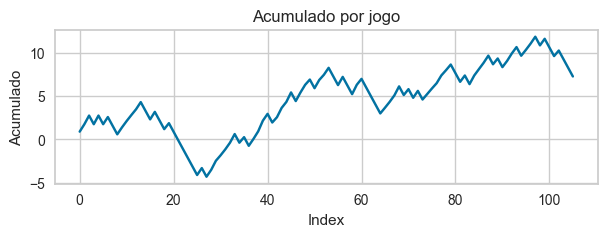


Fold 8 (seed 6891)
PL: 11.34 | ROI: 11.12% | EM: 0.12 | Prec.: 0.62 | Entradas: 0.12
Drawndown: -6.89


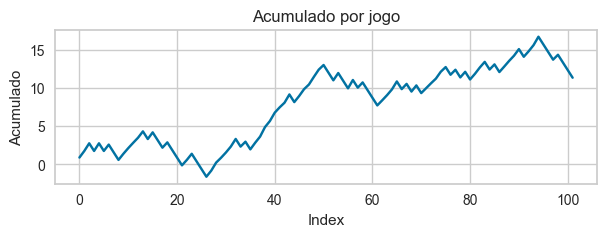


Fold 9 (seed 5670)
PL: 3.69 | ROI: 3.62% | EM: 0.04 | Prec.: 0.58 | Entradas: 0.12
Drawndown: -8.28


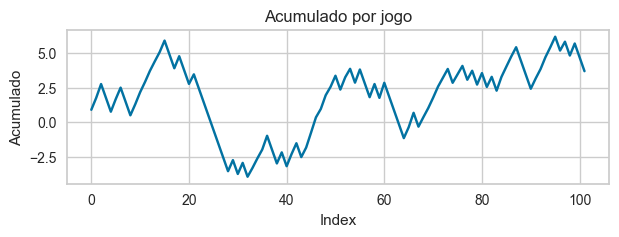


Fold 10 (seed 773)
PL: 8.69 | ROI: 7.30% | EM: 0.08 | Prec.: 0.61 | Entradas: 0.14
Drawndown: -6.57


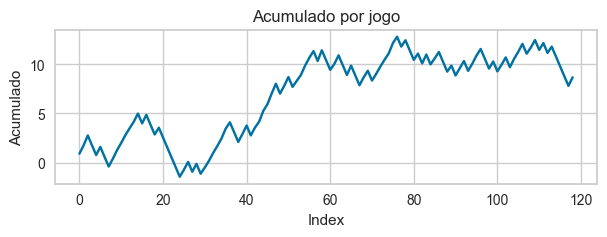


WR  Média: 0.60 | DP: 0.02

PROFIT  Média: 6.42 | DP: 2.91

ROI  Média: 0.06 | DP: 0.03



In [264]:
results_wr = []
results_pl = []
results_roi = []
seeds = random.sample(range(0, 9999), 10)

for i in range(len(seeds)):

        cria_setup(seed=seeds[i], features=features)

        cross_model = create_model('lr', verbose = False, cross_validation=False)
        
        previsoes = predict_model(cross_model, val, verbose = False)
        previsoes = previsoes.merge(df[ODDS], left_index=True, right_index=True, how='left')
        if f'{ODDS}_x' in previsoes.columns.tolist():
                previsoes.rename(columns={f'{ODDS}_x': ODDS}, inplace=True)
                previsoes.drop(columns=f'{ODDS}_y', inplace=True)

        stake = 1

        total = previsoes.shape[0]

        previsoes = previsoes[(previsoes['prediction_label'] == 1)]

        previsoes.loc[(previsoes[TARGET] == 1), 'PL_BF_Predictions'] = (previsoes[ODDS] - 1) * stake
        previsoes.loc[(previsoes[TARGET] == 0), 'PL_BF_Predictions'] = - stake

        ############ Filtro ############
        previsoes = filtra_resultados(previsoes, filtro = 1)
        previsoes = calcula_profit(previsoes)
        metrics = exibe_metricas(previsoes, total = total, return_metrics=True)
        plb = metrics['pl']
        wr = metrics['wr']
        dd = metrics['dd']
        oddback = metrics['oddback']
        med_gain = metrics['med_gain']
        med_loss = metrics['med_loss']
        roi = metrics['roi']
        porc_ent = metrics['porc_ent']
        ev = metrics['ev']
        
        results_wr.append(wr)
        results_pl.append(plb)
        results_roi.append(roi)

        print(f'Fold {i+1} (seed {seeds[i]})')
        print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | EM: {ev:.2f} | Prec.: {wr:.2f} | Entradas: {porc_ent:.2f}')
        print(f'Drawndown: {dd:.2f}')
        exibe_grafico(previsoes)
        print()

print(f'WR  Média: {np.mean(results_wr):.2f} | DP: {np.std(results_wr):.2f}\n')
print(f'PROFIT  Média: {np.mean(results_pl):.2f} | DP: {np.std(results_pl):.2f}\n')
print(f'ROI  Média: {np.mean(results_roi):.2f} | DP: {np.std(results_roi):.2f}\n')

In [ ]:
8027
6383
7107

# Entradas Aleatórias

In [ ]:
def new_random_model(_val, _n):

    for i in range(_n):
        random_df = _val.copy()
        random_df['Entrada'] = [random.choice([0, 1]) for _ in range(len(random_df))]

        random_df = random_df[random_df['Entrada'] == 1]
        random_df.loc[(random_df[TARGET] == 1), 'PL'] = (random_df[ODDS] - 1)
        random_df.loc[(random_df[TARGET] == 0), 'PL'] = -1
        
        random_df.sort_values('Date', inplace=True)
        random_df.reset_index(drop=True, inplace=True)
        random_df['hbacu'] = random_df['PL'].cumsum()
        random_df['hbacu'].plot.line(figsize=(12,6))
    
    plt.show()

In [ ]:
new_random_model(val, 10)